In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import torch as t
from utils.config import opt
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
import numpy as np
import pickle

%matplotlib inline

TRAIN_MODE = False

In [2]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

# Load model trained with caffe pretrained model

In [3]:
%ls ./checkpoints/cars

baseline_results.pickle                 inv_mahal_cov.pickle
fasterrcnn_04151829_0.6704369972064141  kitti_features.pickle
fasterrcnn_04151851_0.6877679369254311  mahalanobis.ipynb*
fasterrcnn_04151914_0.7164561623943497  mahal_cov.pickle
fasterrcnn_04151958_0.7435728692746989  mahal_means.pickle
fasterrcnn_04152043_0.7459420675485349  mahal_result.pickle
fasterrcnn_04152235_0.7462277363985176  pred_bboxes_test.pickle
gt_bboxes_test.pickle                   pred_bboxes_test_softmax.pickle
gt_bboxes_test_softmax.pickle           pred_labels_test.pickle
gt_difficults_test.pickle               pred_labels_test_softmax.pickle
gt_difficults_test_softmax.pickle       pred_scores_test.pickle
gt_labels.pickle                        pred_scores_test_softmax.pickle
gt_labels_test.pickle                   tsne_features.pickle
gt_labels_test_softmax.pickle


In [4]:
trainer.load('./checkpoints/cars/fasterrcnn_04152235_0.7462277363985176')

FasterRCNNTrainer(
  (faster_rcnn): FasterRCNNVGG16(
    (extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): MaxPoo

In [5]:
img = read_image('misc/demo.jpg')
img = t.from_numpy(img)[None]

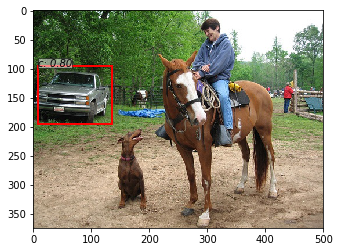

In [6]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)

vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

# Display a Kitti image

In [7]:
import os

dataset_dir = '/media/tadenoud/DATADisk/datasets/kitti_2d'  # School comp
# dataset_dir = '/home/tadenoud/Documents/kitti' # Laptop

img_paths = [
    os.path.join(dataset_dir, 'training/image_2/005009.png'),
    os.path.join(dataset_dir, 'training/image_2/005010.png')
]

imgs = np.array([read_image(p) for p in img_paths])

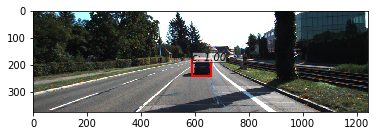

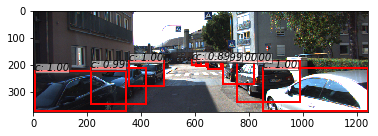

In [8]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(imgs,visualize=True)
vis_bbox(at.tonumpy(imgs[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

vis_bbox(at.tonumpy(imgs[1]),
         at.tonumpy(_bboxes[1]),
         at.tonumpy(_labels[1]).reshape(-1),
         at.tonumpy(_scores[1]).reshape(-1))

# Train mahalanobis features with entire training dataset

In [9]:
from utils.config import opt
from data.dataset import Dataset, TestDataset
from torch.utils.data import DataLoader

print('load data')

opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
dataset = Dataset(opt)
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

if TRAIN_MODE:
    trainer.faster_rcnn.train_ood(dataloader)

    with open('kitti_features.pickle', 'wb') as f:
        pickle.dump(trainer.faster_rcnn.features, f)

    with open('mahal_means.pickle', 'wb') as f:
        pickle.dump(trainer.faster_rcnn.mahal_means, f)

    with open('mahal_cov.pickle', 'wb') as f:
        pickle.dump(trainer.faster_rcnn.mahal_cov, f)

    with open('inv_mahal_cov.pickle', 'wb') as f:
        pickle.dump(trainer.faster_rcnn.inv_mahal_cov, f)

else:
    with open('kitti_features.pickle', 'rb') as f:
        trainer.faster_rcnn.features = pickle.load(f)

    with open('mahal_means.pickle', 'rb') as f:
        mahal_means = pickle.load(f)
        trainer.faster_rcnn.mahal_means = mahal_means

    with open('mahal_cov.pickle', 'rb') as f:
        mahal_cov = pickle.load(f)
        trainer.faster_rcnn.mahal_cov = mahal_cov

    with open('inv_mahal_cov.pickle', 'rb') as f:
        inv_mahal_cov = pickle.load(f)
        trainer.faster_rcnn.inv_mahal_cov = inv_mahal_cov

load data


In [10]:
from tqdm import tqdm

if TRAIN_MODE:
    with open('gt_labels.pickle', 'wb') as f:
        pickle.dump(trainer.faster_rcnn.gt_labels, f)
# else:
    
with open('gt_labels.pickle', 'rb') as f:
    gt_labels = pickle.load(f)

In [11]:
VOC_BBOX_LABEL_NAMES = (
    'car',
    'van',
    'truck',
    'tram',
    'person',
    'person_sitting',
    'cyclist',
    'misc'
    # 'dontcare
)

for j in range(8):
    print(VOC_BBOX_LABEL_NAMES[j], "count:", sum([i == j for i in gt_labels]))

car count: 2602
van count: 0
truck count: 0
tram count: 0
person count: 0
person_sitting count: 0
cyclist count: 0
misc count: 0


# Visualize features using t-SNE

In [12]:
from time import time
from sklearn.manifold import TSNE

if TRAIN_MODE:
    print("Computing t-SNE embedding")
    tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=20)
    t0 = time()
    X_tsne = tsne.fit_transform(trainer.faster_rcnn.features)
    t1 = time()
    
    with open("tsne_features.pickle", "wb") as f:
        pickle.dump(X_tsne, f)

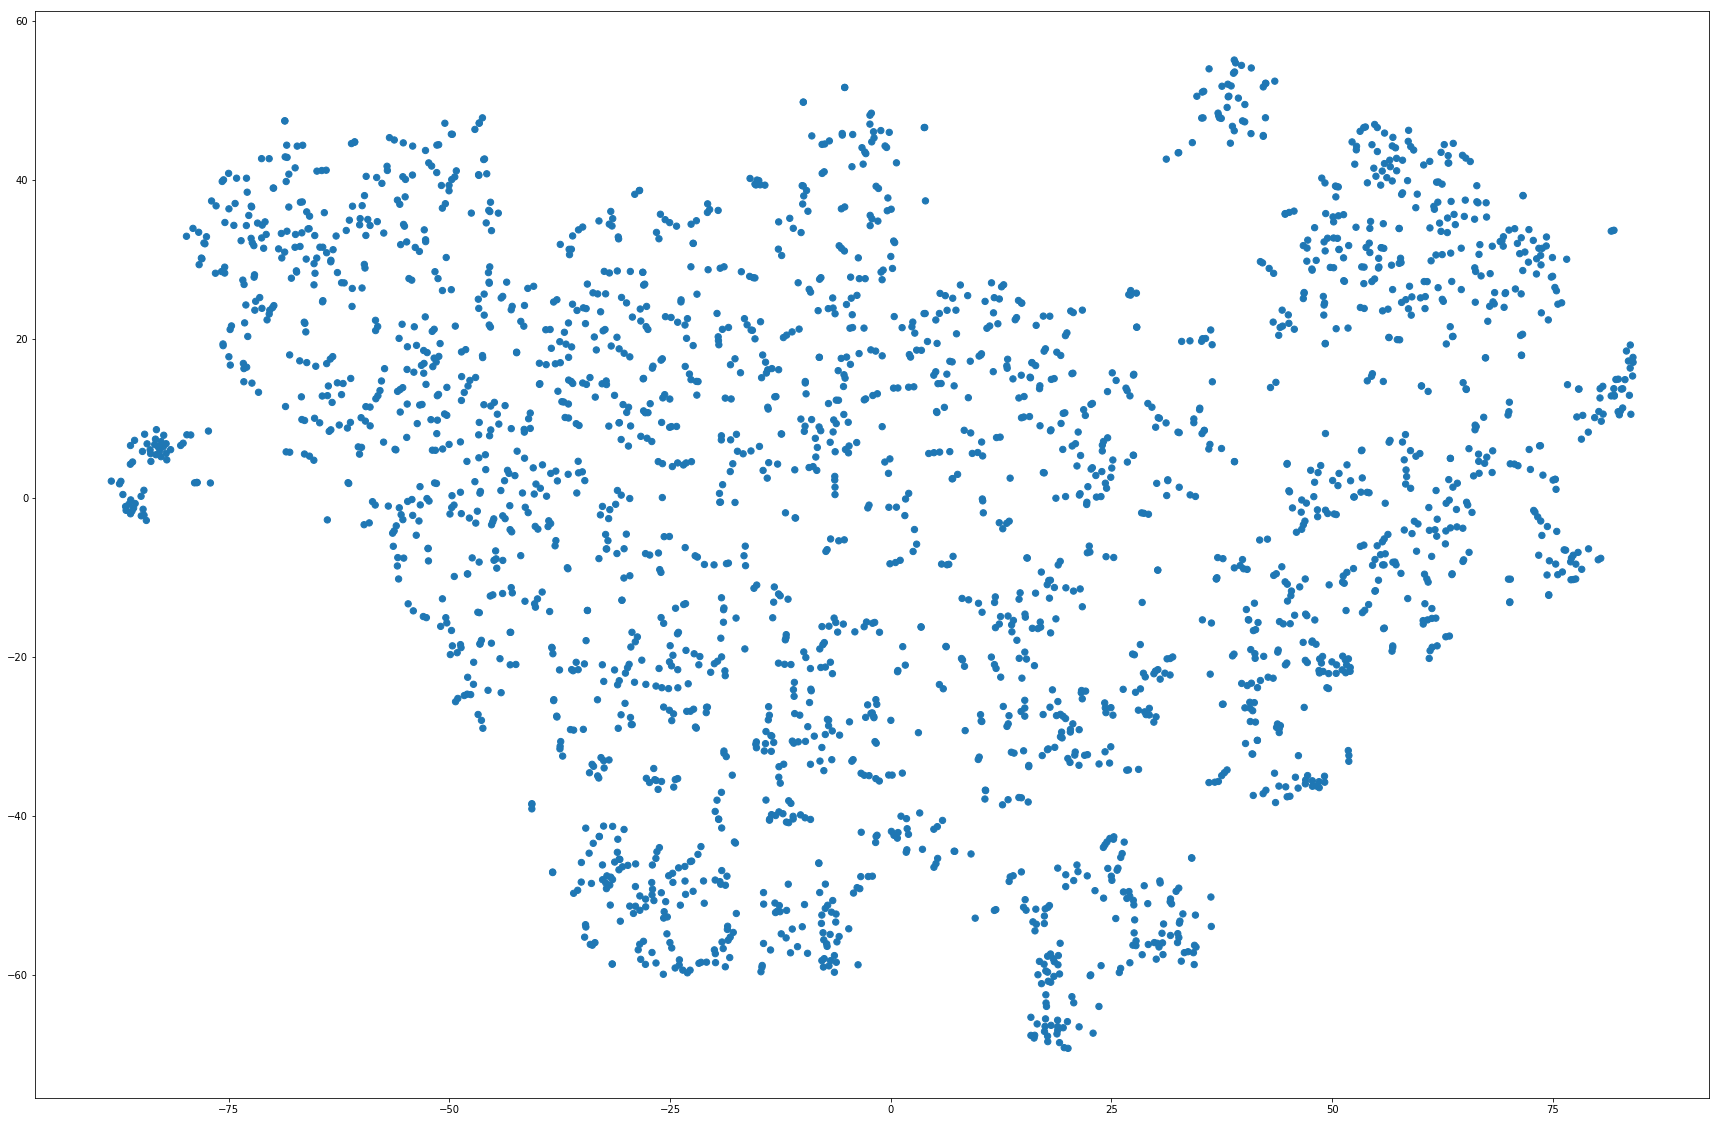

In [13]:
import matplotlib.pyplot as plt

with open("tsne_features.pickle", "rb") as f:
    X_tsne = pickle.load(f)

mask = (gt_labels != -1)
plt.figure(figsize=(30, 20))
plt.scatter(X_tsne[:,0][mask], X_tsne[:,1][mask], c=gt_labels[mask], s=40, cmap=plt.cm.get_cmap('tab10'))
plt.show()

# Predict class using features

In [14]:
# Evaluate baseline softmax method
from train import eval, eval_mahal

print('load data') 
test_dataset = TestDataset(opt)
test_dataloader = DataLoader(test_dataset,
                             batch_size=1,
                             shuffle=False,
                             pin_memory=True,
                             num_workers=opt.num_workers)

if TRAIN_MODE:
    baseline_result = eval(test_dataloader, trainer.faster_rcnn, test_num=opt.test_num)
    with open("baseline_results.pickle", 'wb') as f:
        pickle.dump(baseline_result, f)
    
with open("baseline_results.pickle", 'rb') as f:
    baseline_result = pickle.load(f)
    
print(baseline_result)

load data
{'ap': array([0.74626377]), 'map': 0.7462637677770373}


In [15]:
TRAIN_MODE = True
# Evaluate mahalanobis distance method

if TRAIN_MODE:
    mahal_result = eval_mahal(test_dataloader, trainer.faster_rcnn, test_num=opt.test_num)
    with open("mahal_result.pickle", "wb") as f:
        pickle.dump(mahal_result, f)
else:    
    with open("mahal_result.pickle", "rb") as f:
        mahal_result = pickle.load(f)
    
print(mahal_result)



100%|██████████| 3578/3578 [27:15<00:00,  2.17it/s]

{'ap': array([0.70620091]), 'map': 0.706200905443196}


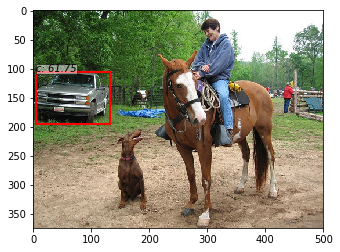

In [16]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis(img,visualize=True)

vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0].reshape(-1)),
         at.tonumpy(_scores[0].reshape(-1)))

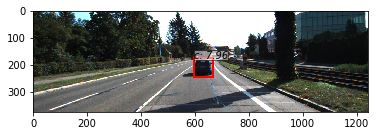

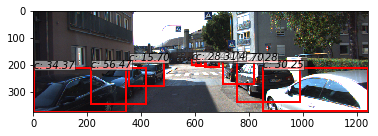

In [17]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis(imgs,visualize=True)

vis_bbox(at.tonumpy(imgs[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

vis_bbox(at.tonumpy(imgs[1]),
         at.tonumpy(_bboxes[1]),
         at.tonumpy(_labels[1]).reshape(-1),
         at.tonumpy(_scores[1]).reshape(-1))

# Do some predictions of "weird car" images from Google

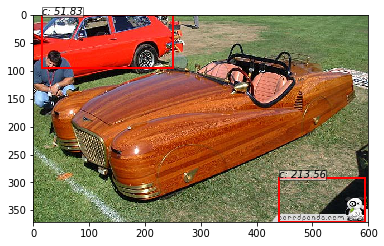

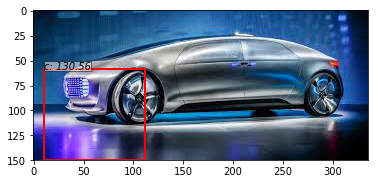

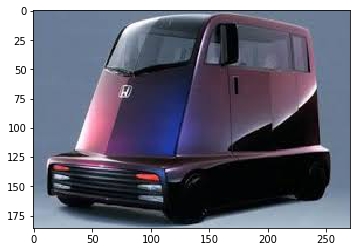

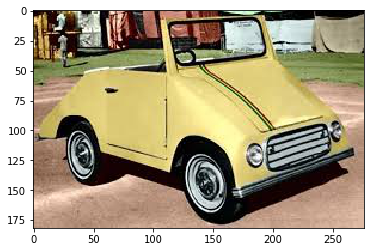

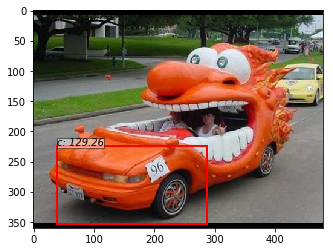

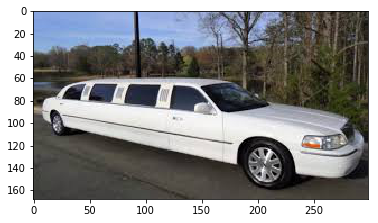

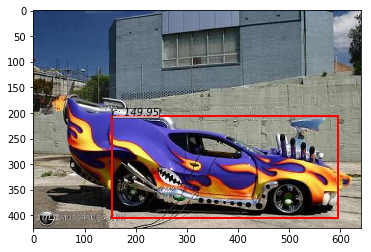

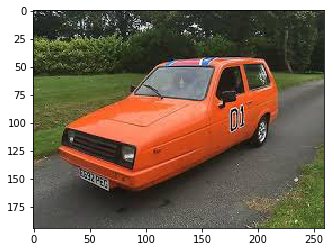

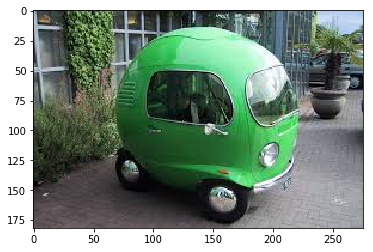

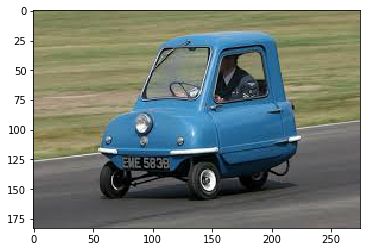

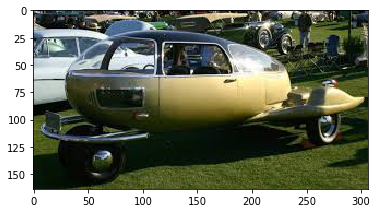

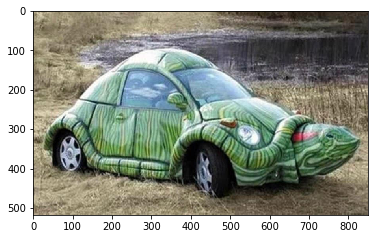

In [18]:
for img_name in os.listdir("./weird_cars"):
    img_path = os.path.join("./weird_cars", img_name)
    im = np.array(read_image(img_path))
    
    _bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis([im], visualize=True)
    
    vis_bbox(at.tonumpy(im),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

# AUROC Mahalanobis on test data

In [19]:
opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
dataset = TestDataset(opt)
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

In [20]:
if TRAIN_MODE:
    features = []
    gt_labels = []

    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels, gt_difficults = list(), list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_, gt_difficults_) in tqdm(enumerate(dataloader), total=opt.test_num):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict_mahalanobis(imgs, [sizes])
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        gt_difficults += list(gt_difficults_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        
    with open("gt_bboxes_test.pickle", "wb") as f:
        pickle.dump(gt_bboxes, f)
    with open("gt_labels_test.pickle", "wb") as f:
        pickle.dump(gt_labels, f)
    with open("gt_difficults_test.pickle", "wb") as f:
        pickle.dump(gt_difficults, f)

    with open("pred_bboxes_test.pickle", "wb") as f:
        pickle.dump(pred_bboxes, f)
    with open("pred_labels_test.pickle", "wb") as f:
        pickle.dump(pred_labels, f)
    with open("pred_scores_test.pickle", "wb") as f:
        pickle.dump(pred_scores, f)

else:
    with open("gt_bboxes_test.pickle", "rb") as f:
        gt_bboxes= pickle.load(f)
    with open("gt_labels_test.pickle", "rb") as f:
        gt_labels = pickle.load(f)
    with open("gt_difficults_test.pickle", "rb") as f:
        gt_difficults = pickle.load(f)

    with open("pred_bboxes_test.pickle", "rb") as f:
        pred_bboxes = pickle.load(f)
    with open("pred_labels_test.pickle", "rb") as f:
        pred_labels = pickle.load(f)
    with open("pred_scores_test.pickle", "rb") as f:
        pred_scores = pickle.load(f)


  8%|▊         | 303/3578 [02:21<25:02,  2.18it/s]


 17%|█▋        | 605/3578 [04:41<22:45,  2.18it/s]


 25%|██▌       | 907/3578 [07:01<20:31,  2.17it/s]


 34%|███▎      | 1205/3578 [09:14<17:48,  2.22it/s]


 42%|████▏     | 1501/3578 [11:30<15:49,  2.19it/s]


 50%|█████     | 1797/3578 [13:46<13:21,  2.22it/s]


 58%|█████▊    | 2093/3578 [15:59<11:11,  2.21it/s]


 67%|██████▋   | 2389/3578 [18:15<08:49,  2.25it/s]


 75%|███████▌  | 2685/3578 [20:32<06:36,  2.25it/s]


 83%|████████▎ | 2981/3578 [22:45<04:29,  2.22it/s]


 92%|█████████▏| 3277/3578 [24:59<02:18,  2.17it/s]


100%|█████████▉| 3573/3578 [27:16<00:02,  2.18it/s]


100%|██████████| 3578/3578 [27:19<00:00,  2.17it/s]
3579it [27:19,  2.14it/s]                          
3580it [27:20,  2.11it/s]
3581it [27:20,  2.10it/s]


In [21]:
IOU_THRESH = 0.5

from model.utils.bbox_tools import bbox_iou

# Ground truth bboxes
print("Ground truth bboxes:", len(np.concatenate(gt_bboxes)))

# Pred bboxes
print("Pred bboxes:", len(np.concatenate(pred_bboxes)))


# Loop through results by image
bboxes_ious = list()
overlapping_bboxes = list()
correct_classification = list()

def iou(bbox, label, gt_boxes, gt_labels, iou_thresh=0.5):
    ious = bbox_iou(np.array([bbox]), gt_boxes)
    best_iou = np.max(ious)
    best_label = gt_labels[np.argmax(ious)]
    
    return best_iou, best_iou > 0 and best_label == label
            

for gt_bbox, gt_label, pred_bbox, pred_label, pred_score in \
        zip(gt_bboxes, gt_labels, pred_bboxes, pred_labels, pred_scores):
    # Calculate if the pred bbox has an overlapping gt_bbox
    bboxes_ious.append([])
    overlapping_bboxes.append([])
    correct_classification.append([])
    for bbox, label, score in zip(pred_bbox, pred_label, pred_score):
        bbox_iou_score, correct_class = iou(bbox, label, gt_bbox, gt_label)
        
        bboxes_ious[-1].append(bbox_iou_score)
        overlapping_bboxes[-1].append(bbox_iou_score > IOU_THRESH)
        correct_classification[-1].append(correct_class)

Ground truth bboxes: 20281
Pred bboxes: 29038


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
from itertools import chain
from metrics import barcode_plot, fpr_at_95_tpr, auroc, detection_error

scores = list(chain(*pred_scores))
overlap_correct = list(chain(*overlapping_bboxes))
class_correct = list(chain(*correct_classification))
both_correct = [a and b for a, b in zip(overlap_correct, class_correct)]

print("AUROC")
print("Overlap", auroc(scores, overlap_correct))
print("Class", auroc(scores, class_correct))
print("Both", auroc(scores, both_correct))
print()
print("FPR@95TPR")
print("Overlap", fpr_at_95_tpr(scores, overlap_correct))
print("Class", fpr_at_95_tpr(scores, class_correct))
print("Both", fpr_at_95_tpr(scores, both_correct))
print()
print("Detection Err")
print("Overlap", detection_error(scores, overlap_correct))
print("Class", detection_error(scores, class_correct))
print("Both", detection_error(scores, both_correct))

In [ ]:
from metrics import barcode_plot, fpr_at_95_tpr, auroc
barcode_plot([-a for a in scores], both_correct)

In [ ]:
# Mahalanobis score vs IoU vs correct classificationplt.figure()
plt.scatter(scores, list(chain(*bboxes_ious)), c=class_correct, cmap='viridis', s=5)
plt.xlabel("Mahalanobis Dist.")
plt.ylabel("IoU with GT")
plt.show()

# AUROC Max Softmax on test data

In [ ]:
opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
dataset = TestDataset(opt)
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

In [ ]:
if TRAIN_MODE:
    features = []
    gt_labels = []

    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_, gt_difficults_) in tqdm(enumerate(dataloader), total=opt.test_num):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs, [sizes])
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_

    with open("pred_bboxes_test_softmax.pickle", "wb") as f:
        pickle.dump(pred_bboxes, f)
    with open("pred_labels_test_softmax.pickle", "wb") as f:
        pickle.dump(pred_labels, f)
    with open("pred_scores_test_softmax.pickle", "wb") as f:
        pickle.dump(pred_scores, f)

else:
    with open("pred_bboxes_test_softmax.pickle", "rb") as f:
        pred_bboxes = pickle.load(f)
    with open("pred_labels_test_softmax.pickle", "rb") as f:
        pred_labels = pickle.load(f)
    with open("pred_scores_test_softmax.pickle", "rb") as f:
        pred_scores = pickle.load(f)
        
with open("gt_bboxes_test.pickle", "rb") as f:
    gt_bboxes = pickle.load(f)
with open("gt_labels_test.pickle", "rb") as f:
    gt_labels = pickle.load(f)
with open("gt_difficults_test.pickle", "rb") as f:
    gt_difficults = pickle.load(f)

In [ ]:
from model.utils.bbox_tools import bbox_iou

# Ground truth bboxes
print("Ground truth bboxes:", len(np.concatenate(gt_bboxes)))

# Pred bboxes
print("Pred bboxes:", len(np.concatenate(pred_bboxes)))

# Loop through results by image
bboxes_ious = list()
overlapping_bboxes = list()
correct_classification = list()

for gt_bbox, gt_label, pred_bbox, pred_label, pred_score in \
        zip(gt_bboxes, gt_labels, pred_bboxes, pred_labels, pred_scores):
    # Calculate if the pred bbox has an overlapping gt_bbox
    bboxes_ious.append([])
    overlapping_bboxes.append([])
    correct_classification.append([])
    for bbox, label, score in zip(pred_bbox, pred_label, pred_score):
        bbox_iou_score, correct_class = iou(bbox, label, gt_bbox, gt_label)
        
        bboxes_ious[-1].append(bbox_iou_score)
        overlapping_bboxes[-1].append(bbox_iou_score > IOU_THRESH)
        correct_classification[-1].append(correct_class)

In [ ]:
from itertools import chain
from sklearn.metrics import roc_auc_score

scores = list(chain(*pred_scores))
overlap_correct = list(chain(*overlapping_bboxes))
class_correct = list(chain(*correct_classification))
both_correct = [a and b for a, b in zip(overlap_correct, class_correct)]

print("AUROC")
print("Overlap", auroc(scores, overlap_correct))
print("Class", auroc(scores, class_correct))
print("Both", auroc(scores, both_correct))
print()
print("FPR@95TPR")
print("Overlap", fpr_at_95_tpr(scores, overlap_correct))
print("Class", fpr_at_95_tpr(scores, class_correct))
print("Both", fpr_at_95_tpr(scores, both_correct))
print()
print("Detection Err")
print("Overlap", detection_error(scores, overlap_correct))
print("Class", detection_error(scores, class_correct))
print("Both", detection_error(scores, both_correct))

In [ ]:
from metrics import barcode_plot
barcode_plot(scores, both_correct)

In [ ]:
# Softmax score vs IoU vs correct classification
plt.figure()
plt.scatter(scores, list(chain(*bboxes_ious)), c=class_correct, cmap='viridis', s=5)
plt.xlabel("Max Softmax")
plt.ylabel("IoU with GT")
plt.show()

In [ ]:
with open("pred_scores_test_softmax.pickle", "rb") as f:
    softmax_scores = pickle.load(f)
    softmax_scores = list(chain(*softmax_scores))
        
with open("pred_scores_test.pickle", "rb") as f:
    mahal_scores = pickle.load(f)
    mahal_scores = list(chain(*mahal_scores))

In [ ]:
# Mahalanobis score vs Softmax score vs IoU
plt.figure()
plt.scatter(softmax_scores, mahal_scores, c=list(chain(*bboxes_ious)), cmap='viridis', s=5)
plt.xlabel("Mahalanobis Dist.")
plt.ylabel("Max Softmax")
leg = plt.colorbar()
leg.set_label("IoU with GT")
plt.show()